In [ ]:
pip install h5py tensorflow scikit-learn

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import h5py
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.transform import resize


def load_and_preprocess_data(file_paths, target_size=(224, 224)):
    images = []
    labels = []
    tumor_masks = []

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as file:
            data = file['cjdata']
            image = np.array(data['image'], dtype=np.float32) / 255.0
            label = data['label'][0, 0] - 1  # Convert labels to 0-indexing
            tumor_mask = np.array(data['tumorMask'], dtype=np.float32)

            # Resize the image to the target size
            image_resized = resize(image, target_size, anti_aliasing=True)
            mask_resized = resize(tumor_mask, target_size, anti_aliasing=True)

            images.append(image_resized)
            labels.append(label)
            tumor_masks.append(mask_resized)

    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    tumor_masks = np.array(tumor_masks)

    # Ensure the images have the correct shape
    images = images.reshape(images.shape[0], target_size[0], target_size[1], 1)
    tumor_masks = tumor_masks.reshape(tumor_masks.shape[0], target_size[0], target_size[1], 1)

    return images, labels ,tumor_masks

# Get the list of file paths in the Google Drive folder
drive_folder = '/content/drive/MyDrive/figshare_dataset/data/'
file_paths = [drive_folder + f'{i}.mat' for i in range(1, 3065)]  # Assuming files are named 1.mat to 3064.mat

# Load and preprocess the data
images, labels, segmentation_masks = load_and_preprocess_data(file_paths)

In [ ]:
from tensorflow.keras.applications import ResNet50
import cv2
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np



In [ ]:
rgb_image = np.repeat(images, 3, axis=-1)


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                         

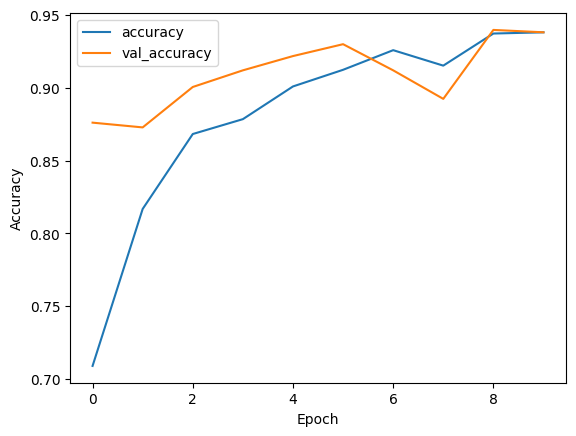

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rgb_image, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Define ResNet50 model using the pre-trained weights on ImageNet
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=('relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation=('relu')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation=('softmax')))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture and layer sizes
model.summary()

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))

# Print accuracy after each epoch
for epoch, acc in enumerate(history.history['accuracy']):
    print(f"Epoch {epoch + 1}/{len(history.history['accuracy'])} - Accuracy: {acc:.4f}")

# Plot accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()